#Kindly consider following baseline implementation of Multilayer Perceptron

In [ ]:
!pip install d2l==1.0.3

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))


    # def loss(self, y_hat, y):
    #     return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()


In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

In [ ]:
data = d2l.FashionMNIST(batch_size=256)

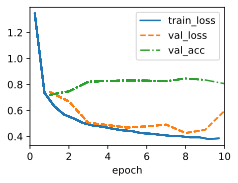

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

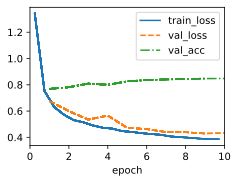

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

#Questions
## Provide empirical evidence using implementation for following questions.

## Q1) Change the number of hidden units num_hiddens and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter? [2 Marks]

Hidden Units: 64, Test Accuracy: 0.8547
Hidden Units: 128, Test Accuracy: 0.8708
Hidden Units: 256, Test Accuracy: 0.8837
Hidden Units: 512, Test Accuracy: 0.8760
Hidden Units: 1024, Test Accuracy: 0.8787


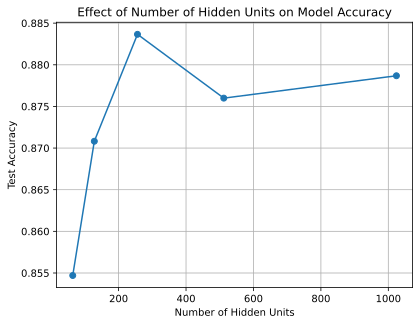

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


hidden_units_list = [64, 128, 256, 512, 1024]
accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for num_hiddens in hidden_units_list:

    model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=num_hiddens, lr=0.1).to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


    model.train()
    for epoch in range(10):  # 10 epochs
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)


            outputs = model(X.view(X.size(0), -1))
            loss = criterion(outputs, y)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    model.eval()
    total_accuracy = 0
    num_batches = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(X.size(0), -1))
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1


    avg_accuracy = total_accuracy / num_batches
    accuracies.append(avg_accuracy)
    print(f'Hidden Units: {num_hiddens}, Test Accuracy: {avg_accuracy:.4f}')


plt.plot(hidden_units_list, accuracies, marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Test Accuracy')
plt.title('Effect of Number of Hidden Units on Model Accuracy')
plt.grid(True)
plt.show()




## Q2)Try adding a hidden layer to see how it affects the results. [2 Marks]

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the updated MLPScratch class with an additional hidden layer using nn.Module
class MLPScratch(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, lr):
        super(MLPScratch, self).__init__()
        self.hidden1 = torch.nn.Linear(num_inputs, num_hiddens1)
        self.hidden2 = torch.nn.Linear(num_hiddens1, num_hiddens2)
        self.output = torch.nn.Linear(num_hiddens2, num_outputs)
        self.loss = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    def forward(self, X):
        X = torch.relu(self.hidden1(X))
        X = torch.relu(self.hidden2(X))
        return self.output(X)

# Define the transformations to convert images to tensor and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the FashionMNIST dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader objects for both training and test datasets
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize the model with two hidden layers
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens1=256, num_hiddens2=128, lr=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define training function
def train_model(model, train_loader, num_epochs):
    model.train()
    criterion = model.loss
    optimizer = model.optimizer
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(X.size(0), -1))  # Flatten the input
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Train the model
train_model(model, train_loader, num_epochs=10)

# Evaluate the model accuracy
def evaluate_accuracy(model, test_loader):
    model.eval()
    total_accuracy = 0
    num_batches = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(X.size(0), -1))  # Flatten the input
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1
    return total_accuracy / num_batches

# Print the test accuracy
avg_accuracy = evaluate_accuracy(model, test_loader)
print(f'Test Accuracy with Two Hidden Layers: {avg_accuracy:.4f}')



Test Accuracy with Two Hidden Layers: 0.8608


## Q3) Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong? [2 Marks]

## Q4) How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs? [2 Marks]

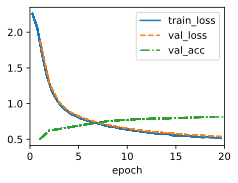

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.01)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

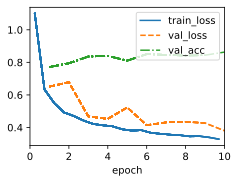

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.2)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

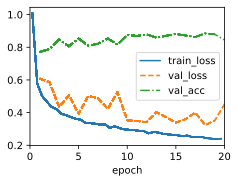

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.5)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

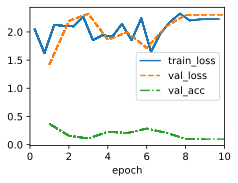

In [ ]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Q5) Let’s optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
### a) What is the best result you can get by optimizing over all of them? [2 Marks]



In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import itertools

# Define the MLPScratch class with variable hidden layers using nn.Module
class MLPScratch(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units, lr):
        super(MLPScratch, self).__init__()
        self.layers = torch.nn.ModuleList()

        # Add hidden layers
        prev_units = num_inputs
        for num_hiddens in hidden_units:
            self.layers.append(torch.nn.Linear(prev_units, num_hiddens))
            prev_units = num_hiddens

        # Output layer
        self.output = torch.nn.Linear(prev_units, num_outputs)
        self.loss = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)

    def forward(self, X):
        for layer in self.layers:
            X = torch.relu(layer(X))
        return self.output(X)

# Define the transformations to convert images to tensor and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the FashionMNIST dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader objects for both training and test datasets
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define training function
def train_model(model, train_loader, num_epochs):
    model.train()
    criterion = model.loss
    optimizer = model.optimizer
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(X.size(0), -1))  # Flatten the input
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Evaluate the model accuracy
def evaluate_accuracy(model, test_loader):
    model.eval()
    total_accuracy = 0
    num_batches = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(X.size(0), -1))  # Flatten the input
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1
    return total_accuracy / num_batches

# Define hyperparameter grid
learning_rates = [ 0.1,0.3,1]
num_epochs_list = [5, 10]
hidden_layer_options = [[128], [256, 128]]  # Different configurations of hidden layers and units

# Perform grid search
best_accuracy = 0
best_params = {}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr, num_epochs, hidden_units in itertools.product(learning_rates, num_epochs_list, hidden_layer_options):
    print(f"Training with lr={lr}, epochs={num_epochs}, hidden units={hidden_units}")

    # Initialize model with current parameters
    model = MLPScratch(num_inputs=784, num_outputs=10, hidden_units=hidden_units, lr=lr)
    model.to(device)

    # Train the model
    train_model(model, train_loader, num_epochs)

    # Evaluate the model
    accuracy = evaluate_accuracy(model, test_loader)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Track the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'lr': lr, 'epochs': num_epochs, 'hidden_units': hidden_units}

# Output the best results
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")


Training with lr=0.1, epochs=5, hidden units=[128]
Test Accuracy: 0.8356
Training with lr=0.1, epochs=5, hidden units=[256, 128]
Test Accuracy: 0.8577
Training with lr=0.1, epochs=10, hidden units=[128]
Test Accuracy: 0.8384
Training with lr=0.1, epochs=10, hidden units=[256, 128]
Test Accuracy: 0.8605
Training with lr=0.3, epochs=5, hidden units=[128]
Test Accuracy: 0.8167
Training with lr=0.3, epochs=5, hidden units=[256, 128]
Test Accuracy: 0.8528
Training with lr=0.3, epochs=10, hidden units=[128]
Test Accuracy: 0.8599
Training with lr=0.3, epochs=10, hidden units=[256, 128]
Test Accuracy: 0.8226
Training with lr=1, epochs=5, hidden units=[128]
Test Accuracy: 0.1954
Training with lr=1, epochs=5, hidden units=[256, 128]
Test Accuracy: 0.0977
Training with lr=1, epochs=10, hidden units=[128]
Test Accuracy: 0.3006
Training with lr=1, epochs=10, hidden units=[256, 128]
Test Accuracy: 0.3109
Best Test Accuracy: 0.8605
Best Hyperparameters: {'lr': 0.1, 'epochs': 10, 'hidden_units': [256,